<a href="https://colab.research.google.com/github/hhoppe/advent_of_code_2021/blob/main/advent_of_code_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of code 2021

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code_2021/blob/main/advent_of_code_2021.ipynb)

IPython/Jupyter [notebook](https://github.com/hhoppe/advent_of_code_2021/blob/main/advent_of_code_2021.ipynb) by [Hugues Hoppe](http://hhoppe.com/) with solutions to the [2021 Advent of Code puzzles](https://adventofcode.com/2021).

Mostly completed in December 2021.

See my [**2020** Advent-of-Code notebook](https://github.com/hhoppe/advent_of_code_2020) for notes on how the code is structured.

<a name="preamble"></a>
## Preamble: Common code

In [1]:
!pip install -q mediapy

In [2]:
import bisect
import collections
import contextlib
import dataclasses
import functools
import heapq
import itertools
import json
import math
import operator
import pathlib
import pprint
import random
import re
import sys
import textwrap
import time
from typing import Any, Callable, Dict, List, Mapping
from typing import Optional, Set, Tuple, Union
import unittest.mock
import urllib.request

import mediapy as media
import numpy as np

In [3]:
!wget -q https://www.dropbox.com/s/8k8go50bc46cwhp/hhoppe_utils.py?raw=1 -O hhoppe_utils.py || echo "wget FAILED"
import hhoppe_utils as hh

In [4]:
YEAR = 2021

In [5]:
# (1) To obtain puzzle inputs and answers, we first try these PATHS/URLS:
PROFILE = 'google.Hugues%20Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
INPUT_PATH_OR_URL_FORMAT = 'https://github.com/hhoppe/advent_of_code_{year}/raw/main/data/{PROFILE}/{year}_{day:02d}_input.txt'
ANSWER_PATH_OR_URL_FORMAT = 'https://github.com/hhoppe/advent_of_code_{year}/raw/main/data/{PROFILE}/{year}_{day:02d}{part_letter}_answer.txt'

In [6]:
# (2) If not found, we optionally try adventofcode.com using a session cookie:
if 0:
  # See https://github.com/wimglenn/advent-of-code-data.
  !rm -f ~/.config/aocd/token*
  # Fill-in the session cookie in the following:
  !if [ '{PROFILE}' == 'google.Hugues%20Hoppe.965276' ]; then mkdir -p ~/.config/aocd && echo 53616... >~/.config/aocd/token; fi
  !if [ '{PROFILE}' == 'github.hhoppe.1452460' ]; then mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token; fi
  !pip install -q advent-of-code-data
  import aocd

In [7]:
try:
  import numba
  using_numba = True
  numba_njit = numba.njit
except ModuleNotFoundError:
  print('numba unavailable')
  using_numba = False
  def noop_decorator(*args: Any, **kwargs: Any) -> Any:
    """Function decorator that ignores any arguments and does nothing."""
    return (args[0] if len(args) == 1 and callable(args[0]) and not kwargs
            else noop_decorator)
  numba_njit = noop_decorator

In [8]:
def check_eq(a: Any, b: Any) -> None:
  if np.any(a != b):
    raise AssertionError(f'{a!r} == {b!r}')


def np_int_from_ch(a, int_from_ch: Mapping[str, int],
                   dtype=None) -> np.ndarray:
  """Returns array of integers by mapping from array of characters."""
  a = np.asarray(a).view(np.int32)
  lookup = np.zeros(np.max(a) + 1, dtype=dtype or np.int64)
  for ch, value in int_from_ch.items():
    lookup[ord(ch)] = value
  return lookup[a]


def grid_from_string(s: str, int_from_ch: Optional[Mapping[str, int]] = None,
    dtype=None) -> np.ndarray:
  """Returns 2D grid (of characters or integers) from a multiline string."""
  if 0:  # slow
    grid = np.array(list(map(list, s.strip('\n').split('\n'))))

  else:  # fast
    lines = s.strip('\n').split('\n')
    height, width = len(lines), len(lines[0])
    grid = np.empty((height, width), dtype='U1')
    dtype_for_row = f'U{width}'
    for i, line in enumerate(lines):
      grid[i].view(dtype_for_row)[0] = line

  if int_from_ch is not None:
    grid = np_int_from_ch(grid, int_from_ch, dtype=dtype)
  return grid


def read_contents(path_or_url: str) -> bytes:
  if path_or_url.startswith(('http://', 'https://')):
    with urllib.request.urlopen(path_or_url) as response:
      data: bytes = response.read()
    return data
  with open(path_or_url, 'rb') as f:
    return f.read()


@dataclasses.dataclass
class PuzzlePart:
  day: int
  part: int
  answer: Optional[str] = None
  func: Optional[Callable[[str], Union[str, int]]] = None
  slow: bool = False
  elapsed_time: float = -0.0

  def compute(self, input: str, silent: bool = False, repeat: int = 1) -> None:
    assert self.func
    if self.slow and not advent.also_run_slow_tests:
      print('Skipping slow computation because `also_run_slow_tests` is False')
      return
    elapsed_times = []
    for _ in range(repeat):
      with contextlib.ExitStack() as stack:
        if silent:
          for f in ('sys.stdout', 'sys.stderr', 'IPython.display.display'):
            stack.enter_context(unittest.mock.patch(f))
        start_time = time.time()
        result = str(self.func(input))
        elapsed_times.append(time.time() - start_time)
      if self.answer is not None:
        if result != self.answer:
          raise AssertionError(f'Result {result!r} != expected {self.answer!r}')
      else:
        print(f'Obtained result {result!r}.')
        if advent.use_aocd:
          puz = aocd.models.Puzzle(year=advent.year, day=self.day)
          if self.part == 1:
            puz.answer_a = result  # Submit.
            if puz.answered_a:
              self.answer = puz.answer_a
          elif self.part == 2:
            puz.answer_b = result
            if puz.answered_b:
              self.answer = puz.answer_b
          else:
            raise AssertionError()
        else:
          self.answer = result
    self.elapsed_time = min(elapsed_times)
    if not silent:
      print(f'(Part {self.part}: {self.elapsed_time:#5.3f} s)', flush=True)


@dataclasses.dataclass
class Puzzle:
  day: int
  input: str = ''
  parts: Dict[int, PuzzlePart] = dataclasses.field(default_factory=dict)  # 1..2
  silent: bool = False

  def __post_init__(self) -> None:
    advent.puzzles[self.day] = self
    if self.input:
      self.input = self.input.lstrip('\n')
    if not self.input and INPUT_PATH_OR_URL_FORMAT:
      path_or_url = INPUT_PATH_OR_URL_FORMAT.format(
          **globals(), year=advent.year, day=self.day)
      try:
        self.input = read_contents(path_or_url).decode()
      except:
        pass
    if not self.input and advent.use_aocd:
      puz = aocd.models.Puzzle(year=advent.year, day=self.day)
      self.input = puz.input_data
    self.input.strip('\n')
    if not self.input:
      raise ValueError('The puzzle input cannot be determined.')
    for part in (1, 2):
      puzzle_part = self.parts[part] = PuzzlePart(self.day, part)
      if ANSWER_PATH_OR_URL_FORMAT:
        path_or_url = ANSWER_PATH_OR_URL_FORMAT.format(
            **globals(), year=advent.year, day=self.day, part=part,
            part_letter='.ab'[part])
        try:
          puzzle_part.answer = read_contents(path_or_url).decode()
        except:
          pass
      if puzzle_part.answer is None and advent.use_aocd:
        puz = aocd.models.Puzzle(year=advent.year, day=self.day)
        if part == 1 and puz.answered_a:
          puzzle_part.answer = puz.answer_a
        if part == 2 and puz.answered_b:
          puzzle_part.answer = puz.answer_b
    if not self.silent:
      self.print_summary()

  def print_summary(self) -> None:
    lines = [(line[:80] + ' ... ' + line[-35:] if len(line) > 120 else line)
            for line in self.input.strip('\n').split('\n')]
    lines2 = lines[:8] + [' ...'] + lines[-4:] if len(lines) > 13 else lines
    s = '\n'.join(lines2)
    print(f'For day {self.day}, puzzle.input has {len(lines)} lines:\n{s}')
    answers = {part: self.parts[part].answer for part in (1, 2)}
    print(f'And the stored answers are: {answers}')

  def verify(self, part: int, func: Callable[[str], Union[str, int]],
            slow: bool = False, repeat: int = 1) -> None:
    puzzle_part = self.parts[part]
    puzzle_part.func = func
    puzzle_part.slow = slow
    puzzle_part.compute(self.input, repeat=repeat)


@dataclasses.dataclass
class Advent:
  year: int
  also_run_slow_tests: bool = False
  puzzles: Dict[int, Puzzle] = dataclasses.field(default_factory=dict)  # [day]

  def __post_init__(self) -> None:
    self.use_aocd = ('aocd' in globals() and
                     pathlib.Path('~/.config/aocd/token').expanduser().exists())

  def puzzle(self, *args: Any, **kwargs: Any) -> Puzzle:
    return Puzzle(*args, **kwargs)

  def show_times(self, recompute: bool = False, repeat: int = 1) -> None:
    if recompute and repeat > 1:
      print(f'(Computing min times over {repeat} calls.)')
    total = 0.0
    for day, puzzle in sorted(self.puzzles.items()):
      s = f'day_{day:<2}'
      for part in (1, 2):
        s += f'   part_{part}:'
        puzzle_part = puzzle.parts.get(part)
        if not puzzle_part:
          s += '  n/a '
          continue
        if recompute and puzzle_part.func:
          puzzle_part.compute(puzzle.input, silent=True, repeat=repeat)
        s += f'{puzzle_part.elapsed_time:#6.3f}'
        total += puzzle_part.elapsed_time
      print(s)
    print(f'Total time:{total:#7.3f} s')


advent = Advent(year=YEAR, also_run_slow_tests=False)

<a name="day1"></a>
## Day 1: Increasing numbers in sequence

- Part 1: How many measurements are larger than the previous measurement?

- Part 2: Consider sums of a three-measurement sliding window. How many sums are larger than the previous sum?

In [9]:
puzzle = advent.puzzle(day=1)

For day 1, puzzle.input has 2000 lines:
198
208
209
212
213
217
218
223
 ...
10902
10903
10931
10930
And the stored answers are: {1: '1791', 2: '1822'}


In [10]:
s1 = """
199
200
208
210
200
207
240
269
260
263
"""

In [11]:
def sliding_window(iterable, n):
  """sliding_window('ABCDEFG', 4) -> ABCD BCDE CDEF DEFG"""
  # From https://docs.python.org/3/library/itertools.html
  it = iter(iterable)
  window = collections.deque(itertools.islice(it, n), maxlen=n)
  if len(window) == n:
    yield tuple(window)
  for x in it:
    window.append(x)
    yield tuple(window)

In [12]:
def process1(s, part2=False):  # Solution based on generators.
  sequence = map(int, s.strip().split('\n'))
  if part2:
    sequence = (sum(window) for window in sliding_window(sequence, 3))
  return sum(a < b for a, b in sliding_window(sequence, 2))


check_eq(process1(s1), 7)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 5)
puzzle.verify(2, process2)

(Part 1: 0.001 s)
(Part 2: 0.003 s)


In [13]:
def process1(s, part2=False):  # Solution using numpy; fastest.
  sequence = list(map(int, s.strip('\n').split('\n')))
  if part2:
    sequence = np.convolve(sequence, [1, 1, 1], mode='valid')
  return np.count_nonzero(np.diff(sequence) > 0)


check_eq(process1(s1), 7)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 5)
puzzle.verify(2, process2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day2"></a>
## Day 2: Commands to move in 2D

- Part 1: What do you get if you multiply your final horizontal position by your final depth?

- Part 2: What do you get if you multiply your final horizontal position by your final depth?

In [14]:
puzzle = advent.puzzle(day=2)

For day 2, puzzle.input has 1000 lines:
forward 3
down 4
forward 3
up 4
down 4
down 6
down 3
down 1
 ...
down 7
forward 5
forward 3
forward 7
And the stored answers are: {1: '2150351', 2: '1842742223'}


In [15]:
s1 = """
forward 5
down 5
forward 8
up 3
down 8
forward 2
"""

In [16]:
def process1(s):
  y, x = 0, 0
  for line in s.strip('\n').split('\n'):
    command, value = line.split(' ')
    value = int(value)
    if command == 'forward':
      x += value
    elif command == 'down':
      y += value
    elif command == 'up':
      y -= value
    else:
      assert False
  return x * y

check_eq(process1(s1), 150)
puzzle.verify(1, process1)

(Part 1: 0.001 s)


In [17]:
def process2(s):
  y, x, aim = 0, 0, 0
  for line in s.strip('\n').split('\n'):
    command, value = line.split(' ')
    value = int(value)
    if command == 'forward':
      x += value
      y += aim * value
    elif command == 'down':
      aim += value
    elif command == 'up':
      aim -= value
    else:
      assert False
  return x * y

check_eq(process2(s1), 900)
puzzle.verify(2, process2)

(Part 2: 0.001 s)


<a name="day3"></a>
## Day 3: Most common chars in strings

- Part 1: Determine the string made up of the the most (and then least) common characters in each position, interpret these two strings as binary numbers, and return their product.

- Part 2: Successively cull the list of strings matching the most common character in each successive position until a single string remain, repeat the process using the least common character, and return the product of those two binary numbers.

In [18]:
puzzle = advent.puzzle(day=3)

For day 3, puzzle.input has 1000 lines:
001000010101
010010111110
001010110111
001001011101
001001010011
001111100111
100000000101
010001011011
 ...
100110010011
100111111011
000010010011
100111101100
And the stored answers are: {1: '3633500', 2: '4550283'}


In [19]:
s1 = """
00100
11110
10110
10111
10101
01111
00111
11100
10000
11001
00010
01010
"""

In [20]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')

  def most_and_least_common(lines):
    t = np.sum([[int(ch) for ch in line] for line in lines], axis=0)
    s1 = ''.join(str(int(b)) for b in t >= (len(lines) + 1) // 2)
    s2 = s1.translate(str.maketrans('01', '10'))
    return s1, s2

  if not part2:
    s1, s2 = most_and_least_common(lines)
    return int(s1, base=2) * int(s2, base=2)
  
  def cull_lines(part):
    lines2 = lines
    for i in itertools.count():
      s = most_and_least_common(lines2)[part]
      lines2 = [line for line in lines2 if line[i] == s[i]]
      if len(lines2) == 1:
        return int(lines2[0], base=2)

  return cull_lines(0) * cull_lines(1)


check_eq(process1(s1), 198)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 230)
puzzle.verify(2, process2)

(Part 1: 0.005 s)
(Part 2: 0.020 s)


<a name="day4"></a>
## Day 4: Bingo

- Part 1: For the first winning board, what is the product of winning number and the sum of the unmarked numbers?

- Part 2: What is this same score for the last winning board?

In [21]:
puzzle = advent.puzzle(day=4)

For day 4, puzzle.input has 601 lines:
83,69,34,46,30,23,19,75,22,37,89,78,32,39,11,44,95,43,26,48,84,53,94,88,18,40,62 ... 16,58,85,87,12,29,25,14,96,56,60,81

68 73 98 51 49
82 56 87 64  8
46  7 21 38 30
66  5 86 97 74
60 63 76 55 39

 ...
53 98 28 52 19
66 51 46 77 15
34 36 47 80 14
 7 89 62  9 49
And the stored answers are: {1: '41668', 2: '10478'}


In [22]:
s1 = """
7,4,9,5,11,17,23,2,0,14,21,24,10,16,13,6,15,25,12,22,18,20,8,19,3,26,1

22 13 17 11  0
 8  2 23  4 24
21  9 14 16  7
 6 10  3 18  5
 1 12 20 15 19

 3 15  0  2 22
 9 18 13 17  5
19  8  7 25 23
20 11 10 24  4
14 21 16 12  6

14 21 17 24  4
10 16 15  9 19
18  8 23 26 20
22 11 13  6  5
 2  0 12  3  7
"""

In [23]:
def process1(s, part2=False):  # More readable.
  sections = s.strip('\n').split('\n\n')
  numbers = list(map(int, sections[0].split(',')))
  boards = np.array([
      [[int(n) for n in line.split()] for line in t.split('\n')]
      for t in sections[1:] 
  ])
  matches = np.full(boards.shape, False)
  scores = []
  previously_finished = np.full(len(boards), False)
  for number in numbers:
    matches[boards == number] = True
    finished = ((matches.sum(axis=1).max(axis=1) == boards.shape[1]) |
                (matches.sum(axis=2).max(axis=1) == boards.shape[2]))
    for winner in np.argwhere(finished & ~previously_finished):
      scores.append(boards[winner][~matches[winner]].sum() * number)
    previously_finished = finished
  
  return scores[-1 if part2 else 0]

In [24]:
def process1(s, part2=False):  # More terse.
  sections = s.strip().split('\n\n')
  boards = np.array([
      [[int(n) for n in line.split()] for line in t.split('\n')]
      for t in sections[1:] 
  ])
  matches = boards < 0
  scores = []
  previously_finished = False
  for number in map(int, sections[0].split(',')):
    matches[boards == number] = True
    finished = ((matches.sum(1).max(1) == boards.shape[1]) |
                (matches.sum(2).max(1) == boards.shape[2]))
    for winner in np.argwhere(finished & ~previously_finished):
      scores.append(boards[winner][~matches[winner]].sum() * number)
    previously_finished = finished
  
  return scores[-int(part2)]


check_eq(process1(s1), 4512)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 1924)
puzzle.verify(2, process2)

(Part 1: 0.011 s)
(Part 2: 0.011 s)


<a name="day5"></a>
## Day 5: Coverage of line segments

- Part 1: Ignoring diagonal segments, what is the count of gridpoints covered by at least two segments?

- Part 2: Including diagonal segments, what is the count of gridpoints covered by at least two segments?

In [25]:
puzzle = advent.puzzle(day=5)

For day 5, puzzle.input has 500 lines:
959,103 -> 139,923
899,63 -> 899,53
591,871 -> 364,644
739,913 -> 310,484
460,309 -> 460,705
351,389 -> 351,837
420,55 -> 420,541
916,520 -> 382,520
 ...
139,153 -> 936,950
436,978 -> 244,978
921,633 -> 921,340
872,63 -> 233,63
And the stored answers are: {1: '7318', 2: '19939'}


In [26]:
s1 = """
0,9 -> 5,9
8,0 -> 0,8
9,4 -> 3,4
2,2 -> 2,1
7,0 -> 7,4
6,4 -> 2,0
0,9 -> 2,9
3,4 -> 1,4
0,0 -> 8,8
5,5 -> 8,2
"""

In [27]:
def process1(s, part2=False):  # Initial implementation.
  count = collections.defaultdict(int)
  for line in s.strip('\n').split('\n'):
    pattern = r'(\d+),(\d+) -> (\d+),(\d+)'
    x1, y1, x2, y2 = map(int, re.fullmatch(pattern, line).groups())
    if y2 < y1:
      y1, x1, y2, x2 = y2, x2, y1, x1
    if x1 != x2 and y1 != y2:
      if part2:
        x, dx = x1, np.sign(x2 - x1)
        for y in range(y1, y2 + 1):
          count[y, x] += 1
          x += dx
    else:
      for y in range(y1, y2 + 1):
        for x in range(min(x1, x2), max(x1, x2) + 1):
          count[y, x] += 1
  
  return sum(v >= 2 for v in count.values())

In [28]:
def process1(s, part2=False):  # Compact but slower; supports any dimension.
  count = collections.Counter()
  for line in s.strip().split('\n'):
    p, q = (np.array(list(map(int, t.split(',')))) for t in line.split(' -> '))
    if part2 or any(p == q):
      d = np.sign(q - p)
      while any(p != q + d):
        count[tuple(p)] += 1
        p += d
  return sum(v >= 2 for v in count.values())

(Part 1: 0.106 s)
(Part 2: 0.193 s)


""

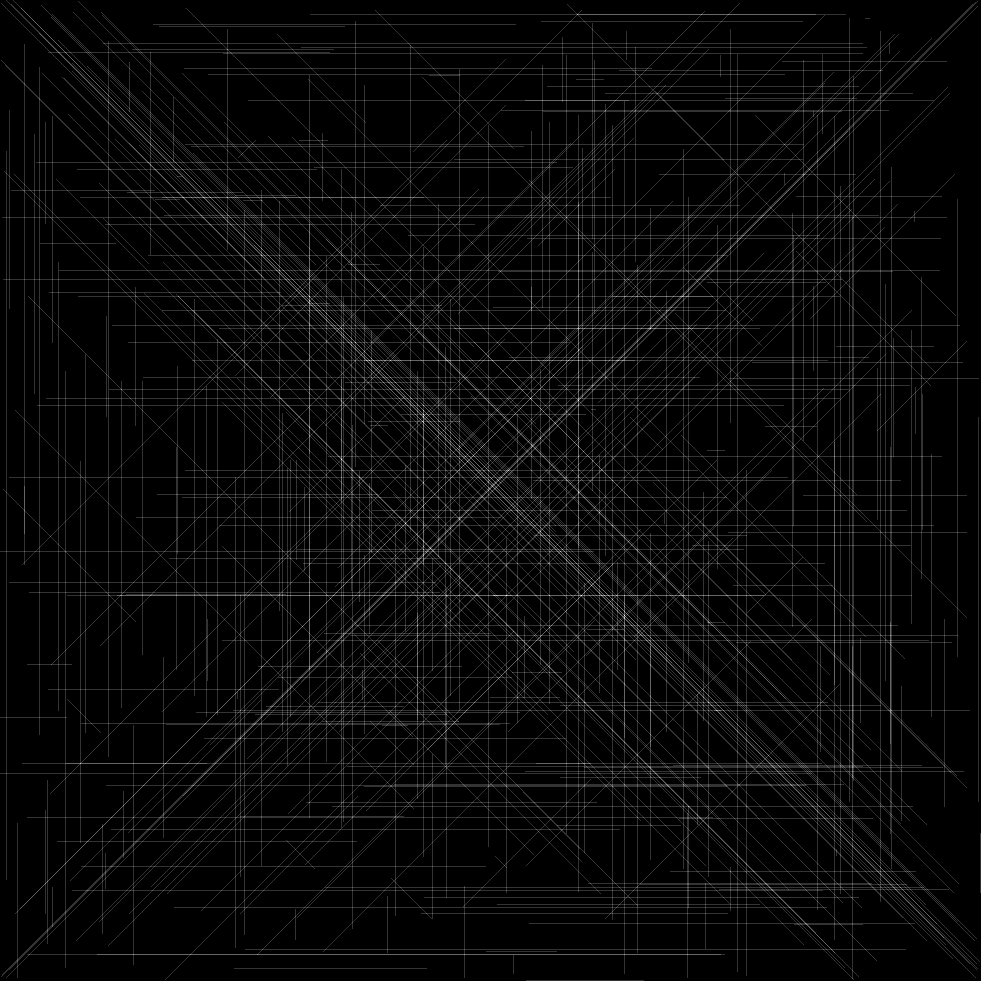

In [29]:
def process1(s, part2=False, visualize=False):  # Fastest.
  count = collections.defaultdict(int)
  for line in s.strip().split('\n'):
    pattern = r'(\d+),(\d+) -> (\d+),(\d+)'
    x1, y1, x2, y2 = map(int, re.fullmatch(pattern, line).groups())
    dx, dy = x2 - x1, y2 - y1
    xinc, yinc = np.sign((dx, dy))
    if dx == 0:
      for _ in range(abs(dy) + 1):
        count[y1, x1] += 1
        y1 += yinc
    elif dy == 0:
      for _ in range(abs(dx) + 1):
        count[y1, x1] += 1
        x1 += xinc
    elif part2:
      for _ in range(abs(dx) + 1):
        count[y1, x1] += 1
        x1, y1 = x1 + xinc, y1 + yinc
  
  if visualize:
    media.show_image(hh.grid_from_indices(count).astype(float))

  return sum(v >= 2 for v in count.values())


check_eq(process1(s1), 5)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 12)
puzzle.verify(2, process2)

_ = process2(puzzle.input, visualize=True)
media.set_max_output_height(2000)

<a name="day6"></a>
## Day 6: Population of lanternfish

- Part 1: How many lanternfish would there be after 80 days?

- Part 2: How many lanternfish would there be after 256 days?

In [30]:
puzzle = advent.puzzle(day=6)

For day 6, puzzle.input has 1 lines:
4,1,1,1,5,1,3,1,5,3,4,3,3,1,3,3,1,5,3,2,4,4,3,4,1,4,2,2,1,3,5,1,1,3,2,5,1,1,4,2, ... 5,5,2,4,2,2,5,2,4,1,3,2,1,1,4,4,1,5
And the stored answers are: {1: '352195', 2: '1600306001288'}


In [31]:
s1 = """3,4,3,1,2"""

In [32]:
def process1(s, part2=False):  # Initial solution, using Counter.
  counter = collections.Counter(map(int, s.strip().split(',')))
  for _ in range(256 if part2 else 80):
    counter2 = collections.Counter()
    for e, count in counter.items():
      if e == 0:
        counter2[8] += count
        counter2[6] += count
      else:
        counter2[e - 1] += count
    counter = counter2
  return sum(counter.values())  # (counter.total() in Python 3.10)

puzzle.verify(1, process1)
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.001 s)
(Part 2: 0.003 s)


In [33]:
def process1(s, part2=False):  # List-based approach used by colleagues.
  counts = [0] * 9
  for i in map(int, s.strip().split(',')):
    counts[i] += 1
  for _ in range(256 if part2 else 80):
    # counts = counts[1:7] + [counts[7] + counts[0]] + counts[8:] + [counts[0]]
    tmp = counts[0]
    counts = counts[1:] + [tmp]
    counts[6] += tmp
  return sum(counts)

puzzle.verify(1, process1)
process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [34]:
if 0:
  # Looking at progression for single input, to ideally derive closed-form
  # expresssion.  However it looks highly irregular.
  def process1(s, part2=False):
    counter = collections.Counter(map(int, s.strip().split(',')))
    for i in range(80):
      counter2 = collections.Counter()
      for e, count in counter.items():
        if e == 0:
          counter2[8] += count
          counter2[6] += count
        else:
          counter2[e - 1] += count
      counter = counter2
      hh.show(i, sum(counter.values()))

  process1('1')

<a name="day7"></a>
## Day 7: Minimize sum of differences

- Part 1: What is the minimal sum of absolute distances?

- Part 2: What is the minimal sum of quadratic-like distances?

In [35]:
puzzle = advent.puzzle(day=7)

For day 7, puzzle.input has 1 lines:
1101,1,29,67,1102,0,1,65,1008,65,35,66,1005,66,28,1,67,65,20,4,0,1001,65,1,65,11 ... 89,189,54,230,205,8,123,247,566,947
And the stored answers are: {1: '354129', 2: '98905973'}


In [36]:
s1 = """16,1,2,0,4,2,7,1,2,14"""

In [37]:
def process1(s, part2=False):  # Brute-force search.
  values = np.array(list(map(int, s.split(','))))

  def func(x):
    diff = np.abs(values - x)
    if part2:
      diff = (diff + 1) * diff // 2
    return diff.sum()

  return min(func(x) for x in range(max(values)))

In [38]:
def process1(s, part2=False):  # Almost closed-form expression.
  values = np.array(list(map(int, s.split(','))))

  if not part2:
    return np.abs(values - int(np.median(values))).sum()

  def func(x):
    diff = np.abs(values - x)
    return ((diff + 1) * diff // 2).sum()
  return min(func(x) for x in np.array([-1, 0, 1]) + int(np.mean(values)))


check_eq(process1(s1), 37)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 168)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day8"></a>
## Day 8: LED with unknown seg map

- Part 1: In the output values, how many times do digits 1, 4, 7, or 8 appear?

- Part 2: What do you get if you add up all of the output values?

In [39]:
puzzle = advent.puzzle(day=8)

For day 8, puzzle.input has 200 lines:
cgaed gcdbfa gcfaed gfcde gadfceb cdbfeg acg eacf eabgd ca | agc efcgbd cag eacf
ga ega edgfa cafed gabd cefagdb begfad ebdgf fcbega cbgdfe | bgdef fdgeb dgabfe gea
ged eg acfgd fdceb cdbefa dgcfe cebfdg edcbga egbf ceadfbg | dfcge dacegbf gcdbaef fdceg
cbefg fedbcg bfdg abgedc fgced edcagf caefb gb fedcbga beg | bdfg cbeaf cfdebg gbe
gecdab gbafd geabdcf ecfa dbcfge cfb afgbc efgbac cf cgbae | fbc fbc cfebgad cf
cbdef febdga fba ba fadecb cgfea adbc cbafe fbedcag egcfbd | dfgbae fdcageb adcefbg efbdc
gecdba ecafbg ecabg bgacfd gecaf feba aedbfgc fca gdfec af | fac af cfa eafbgc
geab adgfc gacef acgefdb gecfba eg dbfgec beacf afedbc ecg | baeg fgadc fagbce edfgbca
 ...
df abfce degbc cfd acgfed gbdf bacfegd efdcb badceg egfcbd | cebgd bgdf bceaf df
bfdc eabdf ebcad fgead bcdeag fba bf bcedgfa cdebfa bcegaf | defba cfbd bdcf fabceg
dbaefcg ec aec dfgbea cafeg aedcbg gacedf egadf gfcba cfde | eac efcd ec egcfda
ecgfdab gcefb bcfa af cgfdbe aegbf eba

In [40]:
s1 = """
be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | fdgacbe cefdb cefbgd gcbe
edbfga begcd cbg gc gcadebf fbgde acbgfd abcde gfcbed gfec | fcgedb cgb dgebacf gc
fgaebd cg bdaec gdafb agbcfd gdcbef bgcad gfac gcb cdgabef | cg cg fdcagb cbg
fbegcd cbd adcefb dageb afcb bc aefdc ecdab fgdeca fcdbega | efabcd cedba gadfec cb
aecbfdg fbg gf bafeg dbefa fcge gcbea fcaegb dgceab fcbdga | gecf egdcabf bgf bfgea
fgeab ca afcebg bdacfeg cfaedg gcfdb baec bfadeg bafgc acf | gebdcfa ecba ca fadegcb
dbcfg fgd bdegcaf fgec aegbdf ecdfab fbedc dacgb gdcebf gf | cefg dcbef fcge gbcadfe
bdfegc cbegaf gecbf dfcage bdacg ed bedf ced adcbefg gebcd | ed bcgafe cdgba cbgef
egadfb cdbfeg cegd fecab cgb gbdefca cg fgcdab egfdb bfceg | gbdfcae bgc cg cgb
gcafb gcf dcaebfg ecagb gf abcdeg gaef cafbge fdbac fegbdc | fgae cfgab fg bagce
"""

In [41]:
print(len(list(itertools.permutations('abcdefg'))))

5040


In [42]:
def process1(s):
  total = 0
  for line in s.strip('\n').split('\n'):
    _, outputs = map(str.split, line.split(' | '))
    total += sum(len(output) in [2, 3, 4, 7] for output in outputs)
  return total

def process1(s):
  return sum(len(output) in [2, 3, 4, 7] for line in s.strip('\n').split('\n')
             for output in line.split(' | ')[1].split())

check_eq(process1(s1), 26)
puzzle.verify(1, process1)

(Part 1: 0.001 s)


In [43]:
def process2(s):  # Most compact.
  lookup = {'abcefg': '0', 'cf': '1', 'acdeg': '2', 'acdfg': '3',
            'bcdf': '4', 'abdfg': '5', 'abdefg': '6', 'acf': '7',
            'abcdefg': '8', 'abcdfg': '9'}
  total = 0

  for line in s.strip('\n').split('\n'):
    inputs, outputs = map(str.split, line.split(' | '))
    for permutation in itertools.permutations('abcdefg'):
      translation = str.maketrans('abcdefg', ''.join(permutation))
      
      def get_digit(segs):
        return lookup.get(''.join(sorted(segs.translate(translation))), None)

      if all(get_digit(input) for input in inputs):
        total += int(''.join(get_digit(output) for output in outputs))
        break
    else:
      raise ValueError(f'Line "{line}" has no consistent mapping.')
  
  return total

check_eq(process2(s1), 61229)
puzzle.verify(2, process2)  # 1.45 s

(Part 2: 1.485 s)


In [44]:
def process2(s):  # Faster.
  lookup = {frozenset(k): str(v) for k, v in
      {'abcefg': 0, 'cf': 1, 'acdeg': 2, 'acdfg': 3, 'bcdf': 4,
       'abdfg': 5, 'abdefg': 6, 'acf': 7, 'abcdefg': 8, 'abcdfg': 9}.items()}
  total = 0

  @functools.lru_cache(maxsize=None)   # (@functools.cache in Python 3.9)
  def digit_mapper(permutation):
    translation = str.maketrans('abcdefg', ''.join(permutation))
    return lambda segs: lookup.get(frozenset(segs.translate(translation)), None)

  for line in s.strip('\n').split('\n'):
    inputs, outputs = map(str.split, line.split(' | '))
    inputs.sort(key=len)  # Optional, for speedup.
    for permutation in itertools.permutations('abcdefg'):
      get_digit = digit_mapper(permutation)
      if all(get_digit(input) for input in inputs):
        total += int(''.join(get_digit(output) for output in outputs))
        break
    else:
      raise ValueError(f'Line "{line}" has no consistent mapping.')
  
  return total

check_eq(process2(s1), 61229)
puzzle.verify(2, process2)  # 0.83 s

(Part 2: 0.814 s)


In [45]:
def process2(s):  # Faster.
  lookup = {'abcefg': 0, 'cf': 1, 'acdeg': 2, 'acdfg': 3, 'bcdf': 4,
            'abdfg': 5, 'abdefg': 6, 'acf': 7, 'abcdefg': 8, 'abcdfg': 9}
  lines = s.strip('\n').split('\n')
  ins, outs = zip(*[map(str.split, line.split(' | ')) for line in lines])
  ins = [[frozenset(input) for input in inputs] for inputs in ins]
  outs = list(outs)
  total = 0

  for permutation in itertools.permutations('abcdefg'):
    translation = str.maketrans(''.join(permutation), 'abcdefg')
    decode = {frozenset(k.translate(translation)): v for k, v in lookup.items()}
    for i in reversed(range(len(ins))):
      if all(input in decode for input in ins[i]):
        total += int(''.join(str(decode[frozenset(output)])
                             for output in outs[i]))
        ins.pop(i), outs.pop(i)

  assert not ins
  return total

check_eq(process2(s1), 61229)
puzzle.verify(2, process2)  # 0.38 s

(Part 2: 0.391 s)


In [46]:
def process2(s):  # Faster.
  lookup = {'abcefg': 0, 'cf': 1, 'acdeg': 2, 'acdfg': 3, 'bcdf': 4,
            'abdfg': 5, 'abdefg': 6, 'acf': 7, 'abcdefg': 8, 'abcdfg': 9}
  valids = {''.join(permutation): set(frozenset(k.translate(
              str.maketrans('abcdefg', ''.join(permutation)))) for k in lookup)
            for permutation in itertools.permutations('abcdefg')}
  total = 0

  for line in s.strip('\n').split('\n'):
    inputs, outputs = map(str.split, line.split(' | '))
    inputs = frozenset(frozenset(input) for input in inputs)
    for permutation, valid in valids.items():
      if inputs == valid:
        translation = str.maketrans('abcdefg', permutation)
        decode = {frozenset(k.translate(translation)): str(v)
                  for k, v in lookup.items()}
        total += int(''.join(decode[frozenset(output)] for output in outputs))
        break
    else:
      raise ValueError(f'Line "{line}" has no consistent mapping.')
  
  return total

check_eq(process2(s1), 61229)
puzzle.verify(2, process2)  # 0.24 s

(Part 2: 0.445 s)


In [47]:
def process2(s):  # Faster.
  lookup = {'abcefg': 0, 'cf': 1, 'acdeg': 2, 'acdfg': 3, 'bcdf': 4,
            'abdfg': 5, 'abdefg': 6, 'acf': 7, 'abcdefg': 8, 'abcdfg': 9}
  lines = {(frozenset(frozenset(input) for input in inputs),
            tuple(frozenset(output) for output in outputs))
           for line in s.strip('\n').split('\n')
           for inputs, outputs in [map(str.split, line.split(' | '))]}
  total = 0

  for permutation in itertools.permutations('abcdefg'):
    translation = str.maketrans(''.join(permutation), 'abcdefg')
    valid = frozenset(frozenset(k.translate(translation)) for k in lookup)
    decode = {frozenset(k.translate(translation)): v for k, v in lookup.items()}
    processed_lines = set()
    for line in lines:
      inputs, outputs = line
      if inputs == valid:
        total += int(''.join(str(decode[output]) for output in outputs))
        processed_lines.add(line)
    lines -= processed_lines

  assert not lines
  return total

check_eq(process2(s1), 61229)
puzzle.verify(2, process2)  # 0.16 s

(Part 2: 0.207 s)


In [48]:
def process2(s):  # Custom solution for 8-seg LED; fastest.
  total = 0
  segs_from_digit = {}  # digit 0..9 -> frozenset of segments.
  rules = [  # [digit, len(segs), predicate(segs)].
      [1, 2, lambda e: True],
      [7, 3, lambda e: True],
      [4, 4, lambda e: True],
      [8, 7, lambda e: True],
      [3, 5, lambda e: e > segs_from_digit[1]],
      [6, 6, lambda e: not e > segs_from_digit[1]],
      [9, 6, lambda e: e > segs_from_digit[3]],
      [0, 6, lambda e: True],
      [2, 5, lambda e: not e < segs_from_digit[9]],
      [5, 5, lambda e: True],
  ]

  for line in s.strip('\n').split('\n'):
    inputs, outputs = map(str.split, line.split(' | '))
    inputs = set(frozenset(input) for input in inputs)
    segs_from_digit.clear()
    for digit, length, predicate in rules:
      segs, = (e for e in inputs if len(e) == length and predicate(e))
      segs_from_digit[digit] = segs
      inputs.remove(segs)
    digit_from_segs = {segs: digit for digit, segs in segs_from_digit.items()}
    total += int(''.join(
        str(digit_from_segs[frozenset(output)]) for output in outputs))

  return total

check_eq(process2(s1), 61229)
puzzle.verify(2, process2)  # 0.01 s

(Part 2: 0.007 s)


<a name="day9"></a>
## Day 9: Heightmap basins

- Part 1: What is the sum of the risk levels of all low points on your heightmap?

- Part 2: What do you get if you multiply together the sizes of the three largest basins?

In [49]:
puzzle = advent.puzzle(day=9)

For day 9, puzzle.input has 100 lines:
5456789349886456890123985435578996543213456789656899996467789234989765442345789778999989652349879899
4349891298765348789339875323456789665434568996545698874356679959879898321457893569998879931998765668
1298910989873234595498764312345678976746899989656987563234567899767987442578954678987968899897654457
2987939875432123489999953201234599698657979979997965432023479998959876553689965789876856789789543345
9896899984321012668899865313546789569798965469879876553135568987643988767997896898765945697698722256
8765789965442143456789996579658895434999876398767987864589679876542099898966789999833123598589810123
9954629876553234667899987988767932129899989219755398878678989987943989959355678998921057987678924345
6543212989654345788999898999998941098789998998543229989789797999899876543134989997632345698789545456
 ...
2324579569889834578965789998976899876679876544567892346899986545992198765767893345997569987654568999
10124596987793235699546789679979877645899974323

In [50]:
s1 = """
2199943210
3987894921
9856789892
8767896789
9899965678
"""

In [51]:
class UnionFind:
  """Union-find is an efficient technique for tracking equivalence classes as
  pairs of elements are incrementally unified into the same class.
  The implementation uses path compression but without weight-balancing, so the
  worst case time complexity is O(nlogn), but the average case is O(n).
  """

  def __init__(self):
    self._rep = {}

  def unify(self, a: Any, b: Any) -> None:
    """Merge the equivalence classes of elements a and b."""
    rep_a, rep_b = self.get_rep(a), self.get_rep(b)
    self._rep[rep_b] = rep_a

  def same(self, a: Any, b: Any) -> bool:
    """Returns whether a and b are in the same equivalence class."""
    return self._rep.get(a, a) == self._rep.get(b, b)

  def get_rep(self, a: Any) -> Any:
    """Returns a representative for the class of a; valid until next unify()."""
    if a not in self._rep:
      return a
    parents = []
    while True:
      parent = self._rep.setdefault(a, a)
      if parent == a:
        break
      parents.append(a)
      a = parent
    for p in parents:
      self._rep[p] = a
    return a

In [52]:
def process1(s, part2=False):  # Solution using Union-Find.  Slower.
  grid = hh.grid_from_string(s).astype(int)
  dyxs = np.array([(0, -1), (0, 1), (-1, 0), (1, 0)])
  t = np.pad(grid, 1, constant_values=10)
  neighbors = np.array([np.roll(t, -dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs])
  low_point = (grid[None] < neighbors).all(axis=0)
  
  if not part2:
    return (grid[low_point] + 1).sum()

  downward = dyxs[neighbors.argmin(axis=0)]
  downward[grid == 9] = 0

  union_find = UnionFind()
  for yx in np.ndindex(grid.shape):
    union_find.unify(yx, tuple(yx + downward[yx]))

  rep = np.array([[union_find.get_rep((y, x)) for x in range(grid.shape[1])]
                  for y in range(grid.shape[0])])

  _, count = np.unique(rep.reshape(-1, 2), axis=0, return_counts=True)
  return np.prod(sorted(count)[-3:])


check_eq(process1(s1), 15)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 1134)
puzzle.verify(2, process2)

(Part 1: 0.007 s)
(Part 2: 0.123 s)


In [53]:
def process1(s, part2=False, visualize=False):  # Faster using numpy.
  grid = np.array([list(line) for line in s.strip().split('\n')]).astype(int)
  dyxs = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])
  t = np.pad(grid, 1, constant_values=10)
  neighbors = np.array([np.roll(t, -dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs])
  low_point = (grid < neighbors).all(axis=0)

  if not part2:
    return (grid[low_point] + 1).sum()

  downward = dyxs[neighbors.argmin(axis=0)]
  downward[grid == 9] = downward[low_point] = 0
  
  yx = np.array(np.indices(grid.shape))
  for _ in range(8):
    yx += np.moveaxis(downward[tuple(yx)], -1, 0)

  _, count = np.unique(yx.reshape(2, -1), axis=1, return_counts=True)

  if visualize:
    np.random.seed(0)
    _, inverse = np.unique(yx.reshape(2, -1), axis=1, return_inverse=True)
    cmap = np.uint8(np.random.choice(range(30, 150), (len(count), 3)))
    cmap[count == 1] = 0
    cmap[count >= heapq.nlargest(3, count)[-1]] += 100  # 2 are tied for third!
    basin = cmap[inverse.reshape(grid.shape)]
    basin[low_point] = 255
    images = {'Heightmap': grid.astype(float), 'Basins': basin}
    media.show_images(images, height=grid.shape[0] * 3)

  return np.prod(heapq.nlargest(3, count))


check_eq(process1(s1), 15)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 1134)
puzzle.verify(2, process2)

(Part 1: 0.005 s)
(Part 2: 0.022 s)


(Part 1: 0.003 s)
(Part 2: 0.008 s)


Heightmap,Basins

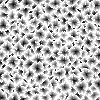
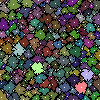

In [54]:
def process1(s, part2=False, visualize=False):  # Faster, using flat indexing.
  grid = np.array([[int(c) for c in line] for line in s.strip().split('\n')])
  dyxs = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])
  t = np.pad(grid, 1, constant_values=10)
  neighbors = np.array([np.roll(t, -dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs])
  low_point = (grid < neighbors).all(axis=0)

  if not part2:
    return (grid[low_point] + 1).sum()

  downward = dyxs[neighbors.argmin(axis=0)]
  downward[grid == 9] = downward[low_point] = 0
  downward = downward.dot(np.cumprod([1, *grid.shape[-1:0:-1]])[::-1]).ravel()

  indices = functools.reduce(lambda indices, _: indices + downward[indices],
                             range(8), np.arange(grid.size))
  _, count = np.unique(indices, return_counts=True)

  if visualize:
    np.random.seed(0)
    _, inverse = np.unique(indices, return_inverse=True)
    cmap = np.uint8(np.random.choice(range(30, 150), (len(count), 3)))
    cmap[count == 1] = 0
    cmap[count >= heapq.nlargest(3, count)[-1]] += 100  # 2 are tied for third!
    basin = cmap[inverse.reshape(grid.shape)]
    basin[low_point] = 255
    images = {'Heightmap': grid.astype(float), 'Basins': basin}
    media.show_images(images, height=grid.shape[0] * 3)

  return np.prod(heapq.nlargest(3, count))


check_eq(process1(s1), 15)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 1134)
puzzle.verify(2, process2)

_ = process2(puzzle.input, visualize=True)

<a name="day10"></a>
## Day 10: Parsing parentheses

- Part 1: What is the total syntax error score for those errors?

- Part 2: For all incomplete inputs, compute an auto-complete score.  What is the middle score?

In [55]:
puzzle = advent.puzzle(day=10)

For day 10, puzzle.input has 90 lines:
(((<(([{{((<[[<><>]<()[]>]{[{}()]<(){}>}>[<([]{})>])(<<(<><>>[<><>]>(<{}()><(){}>)>[(([])<[]()>)])){<((<{}()
{(({({<[[[{[{({}{})[[]{}]}[{(){}}((){})]][{((){}){[]{}}}<(()())<<><>>>]}]]]{([<{<<()()>([][])>({[]()}[{}<
[[{<(([<<{(<[[()()]]{[[]()]<{}>}><{{{}()}<<>[]>><(())[()[]]>>)([{[[][]][()()]}{{()()}}](<{{}()}>))}[([{<<
{<[{<{[({[[[[{<>{}}<{}()>]<{<><>}{[][]}>](<<<>[]>[()()]>[{[]{}>[<>()]])]{{{[()()][<><>]}<[{}()][{}{}]
(<[{[{[((<{[[<()()><{}{}>][(<>{}){{}{}}]]{<[<><>]>{{{}[]}(<>[])}}}(<[[[]{}](<>{})]{[[][]][[][]]}>)>)){<{
<<<(<(<[[[<[{{[]<>}([]())}([[]])]([[[]<>][()()]]{<()()>([]{})])>]{[[<{[]{}}([]{})>{(<>[]){{}{}}}]]{({{<>[]
[{<(({(<{<{<<{<><>}>({<><>}<<><>>)}{[{[]<>}[[][]]][<()<>>]}}<[[[()()]{<><>}]((<>)[{}()])]{<{()<>}
<[([{{{({<({(<(){}><[]()>)((()())[[]()})})[<{<<>>((){})}<[<><>]{(){}}>>{{(<>[])({}[])}(<()<>>)}]>})}({{({
 ...
([{[{<<<[{{({[{}()]}<<<>[]>{<>[]}>)((([]<>))([<>{}]))}{{[([]{})<(){}>}((()[])<[]()>)}({[(){}
[({[<[[[(((<<[[]]<[]<>>>

In [56]:
s1 = """
[({(<(())[]>[[{[]{<()<>>
[(()[<>])]({[<{<<[]>>(
{([(<{}[<>[]}>{[]{[(<()>
(((({<>}<{<{<>}{[]{[]{}
[[<[([]))<([[{}[[()]]]
[{[{({}]{}}([{[{{{}}([]
{<[[]]>}<{[{[{[]{()[[[]
[<(<(<(<{}))><([]([]()
<{([([[(<>()){}]>(<<{{
<{([{{}}[<[[[<>{}]]]>[]]
"""

In [57]:
def process1(s):
  open_from_close = {')': '(', ']': '[', '}': '{', '>': '<'}
  total = 0
  for line in s.strip('\n').split('\n'):
    stack = []
    for i in range(len(line)):
      if line[i] in '([{<':
        stack.append(line[i])
      elif stack.pop() != open_from_close[line[i]]:
        total += {')': 3, ']': 57, '}': 1197, '>': 25137, '': 0}[line[i]]

  return total

check_eq(process1(s1), 26397)
puzzle.verify(1, process1)

(Part 1: 0.004 s)


In [58]:
def process2(s):
  open_from_close = {')': '(', ']': '[', '}': '{', '>': '<'}
  scores = []
  for line in s.strip('\n').split('\n'):
    stack = []
    for i in range(len(line)):
      if line[i] in '([{<':
        stack.append(line[i])
      elif stack.pop() != open_from_close[line[i]]:
        break
    else:
      score = 0
      while stack:
        score = score * 5 + {'(': 1, '[': 2, '{': 3, '<': 4}[stack.pop()]
      scores.append(score)
      continue

  return int(np.median(scores))

check_eq(process2(s1), 288957)
puzzle.verify(2, process2)

(Part 2: 0.002 s)


<a name="day11"></a>
## Day 11: 

- Part 1: ?

- Part 2: ?

In [59]:
# puzzle = advent.puzzle(day=11)

In [60]:
s1 = """
"""

In [61]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [62]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day12"></a>
## Day 12: 

- Part 1: ?

- Part 2: ?

In [63]:
# puzzle = advent.puzzle(day=12)

In [64]:
s1 = """
"""

In [65]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [66]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day13"></a>
## Day 13: 

- Part 1: ?

- Part 2: ?

In [67]:
# puzzle = advent.puzzle(day=13)

In [68]:
s1 = """
"""

In [69]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [70]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day14"></a>
## Day 14: 

- Part 1: ?

- Part 2: ?

In [71]:
# puzzle = advent.puzzle(day=14)

In [72]:
s1 = """
"""

In [73]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [74]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day15"></a>
## Day 15: 

- Part 1: ?

- Part 2: ?

In [75]:
# puzzle = advent.puzzle(day=15)

In [76]:
s1 = """
"""

In [77]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [78]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day16"></a>
## Day 16: 

- Part 1: ?

- Part 2: ?

In [79]:
# puzzle = advent.puzzle(day=16)

In [80]:
s1 = """
"""

In [81]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [82]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day17"></a>
## Day 17: 

- Part 1: ?

- Part 2: ?

In [83]:
# puzzle = advent.puzzle(day=17)

In [84]:
s1 = """
"""

In [85]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [86]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day18"></a>
## Day 18: 

- Part 1: ?

- Part 2: ?

In [87]:
# puzzle = advent.puzzle(day=18)

In [88]:
s1 = """
"""

In [89]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [90]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day19"></a>
## Day 19: 

- Part 1: ?

- Part 2: ?

In [91]:
# puzzle = advent.puzzle(day=19)

In [92]:
s1 = """
"""

In [93]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [94]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day20"></a>
## Day 20: 

- Part 1: ?

- Part 2: ?

In [95]:
# puzzle = advent.puzzle(day=20)

In [96]:
s1 = """
"""

In [97]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [98]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day21"></a>
## Day 21: 

- Part 1: ?

- Part 2: ?

In [99]:
# puzzle = advent.puzzle(day=21)

In [100]:
s1 = """
"""

In [101]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [102]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day22"></a>
## Day 22: 

- Part 1: ?

- Part 2: ?

In [103]:
# puzzle = advent.puzzle(day=22)

In [104]:
s1 = """
"""

In [105]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [106]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day23"></a>
## Day 23: 

- Part 1: ?

- Part 2: ?

In [107]:
# puzzle = advent.puzzle(day=23)

In [108]:
s1 = """
"""

In [109]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [110]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day24"></a>
## Day 24: 

- Part 1: ?

- Part 2: ?

In [111]:
# puzzle = advent.puzzle(day=24)

In [112]:
s1 = """
"""

In [113]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [114]:
process2 = functools.partial(process1, part2=True)
# check_eq(process2(s1), 16)
# puzzle.verify(2, process2)

<a name="day25"></a>
## Day 25: 

- Part 1: ?

- Part 2: ?

In [115]:
# puzzle = advent.puzzle(day=25)

In [116]:
s1 = """
"""

In [117]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  for line in lines:
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

In [118]:
# puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

<a name="timings"></a>
## Timings

In [119]:
advent.show_times()

day_1    part_1: 0.001   part_2: 0.001
day_2    part_1: 0.001   part_2: 0.001
day_3    part_1: 0.005   part_2: 0.020
day_4    part_1: 0.011   part_2: 0.011
day_5    part_1: 0.106   part_2: 0.193
day_6    part_1: 0.000   part_2: 0.000
day_7    part_1: 0.000   part_2: 0.001
day_8    part_1: 0.001   part_2: 0.007
day_9    part_1: 0.003   part_2: 0.008
day_10   part_1: 0.004   part_2: 0.002
Total time:  0.376 s


In [120]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [121]:
if 0:  # Look for unwanted pollution of namespace.
  print(textwrap.fill(' '.join(var for var, value in globals().items() if (
      not var.startswith('_') and not repr(value).startswith(
          ('<module', '<class', 'typing.', 'functools.partial('))))))

In [123]:
if 0:  # Save puzzle inputs and answers to a ZIP file for downloading.
  # Create a new zip file, quietly (-q) and ignoring relative paths (-j).
  !zip -q -j - ~/.config/aocd/'{urllib.parse.unquote(PROFILE)}'/*.txt >/content/data.zip

# End